# Besoin client 1 : Visualisation sur carte
Ce notebook répond à la demande de regrouper automatiquement les navires selon des schémas de navigation similaires (vitesses, routes/directions, heading…) via des techniques de clustering.

L’objectif est d’identifier des comportements typiques, détecter des anomalies ou optimiser les itinéraires.

## Étapes suivies :
1. Préparation des données
2. Apprentissage non supervisé (clustering)
3. Évaluation par métriques
4. Visualisation sur carte
5. Script de prédiction pour un nouveau navire

## 1. Préparation des données
- Sélection des colonnes pertinentes
- Encodage des variables catégorielles
- Nettoyage des données (suppression des valeurs manquantes)

**Justification des variables sélectionnées :**
Les variables choisies (`LAT`, `LON`, `SOG`, `COG`, `Length`, `Width`, `Draft`, `Heading`, `VesselType`) sont directement liées à la navigation et à la typologie des navires. Elles permettent de caractériser les schémas de navigation.

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Chargement des données
df = pd.read_csv('After_Sort_sans_l&w_vide.csv')
colonnes = ['LAT', 'LON', 'SOG', 'COG', 'Length', 'Width', 'Draft', 'Heading', 'VesselType']
df = df[colonnes]
df['VesselType_original'] = df['VesselType']  # Pour affichage ultérieur
df = df.dropna()

# Encodage de la variable catégorielle
if 'VesselType' in df.columns:
    le = LabelEncoder()
    df['VesselType'] = le.fit_transform(df['VesselType'])

## 2. Apprentissage non supervisé (Clustering)
- Normalisation des données
- Réduction de dimensionnalité (PCA)
- Clustering (KMeans)

**Justification du modèle :**
KMeans est choisi pour sa simplicité, sa rapidité et sa capacité à regrouper des objets similaires dans des clusters sphériques. Il nécessite des données numériques et standardisées, ce qui est assuré par le prétraitement.

**Principe de fonctionnement :**
KMeans partitionne les données en k groupes en minimisant la variance intra-cluster. Chaque point est affecté au centre de cluster le plus proche.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Préparation du DataFrame pour le modèle
model_features = ['LAT', 'LON', 'SOG', 'COG', 'Length', 'Width', 'Draft', 'Heading', 'VesselType']
df_model = df[model_features]

# Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(df_model)

# Réduction de dimensionnalité
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
print('Forme des données après PCA :', X_pca.shape)
print('Variance totale expliquée par PCA :', pca.explained_variance_ratio_.sum())

Forme des données après PCA : (220567, 5)
Variance totale expliquée par PCA : 0.8698305344378954


## 3. Métriques pour apprentissage non supervisé
- Silhouette Score
- Calinski-Harabasz Index
- Davies-Bouldin Index

**Justification des métriques :**
- **Silhouette Score** : mesure la cohésion et la séparation des clusters (plus proche de 1, mieux c'est)
- **Calinski-Harabasz** : rapport dispersion inter/intra-cluster (plus grand, mieux c'est)
- **Davies-Bouldin** : similarité inter-cluster (plus petit, mieux c'est)

On teste plusieurs valeurs de k pour choisir le meilleur nombre de clusters.

Calcul des scores pour 2 clusters...
Calcul des scores pour 3 clusters...
Calcul des scores pour 3 clusters...
Calcul des scores pour 4 clusters...
Calcul des scores pour 4 clusters...
Calcul des scores pour 5 clusters...
Calcul des scores pour 5 clusters...
Calcul des scores pour 6 clusters...
Calcul des scores pour 6 clusters...
Calcul des scores pour 7 clusters...
Calcul des scores pour 7 clusters...
Calcul des scores pour 8 clusters...
Calcul des scores pour 8 clusters...
Calcul des scores pour 9 clusters...
Calcul des scores pour 9 clusters...
Calcul des scores pour 10 clusters...
Calcul des scores pour 10 clusters...


Calcul des scores pour 2 clusters...
Calcul des scores pour 3 clusters...
Calcul des scores pour 3 clusters...
Calcul des scores pour 4 clusters...
Calcul des scores pour 4 clusters...
Calcul des scores pour 5 clusters...
Calcul des scores pour 5 clusters...
Calcul des scores pour 6 clusters...
Calcul des scores pour 6 clusters...
Calcul des scores pour 7 clusters...
Calcul des scores pour 7 clusters...
Calcul des scores pour 8 clusters...
Calcul des scores pour 8 clusters...
Calcul des scores pour 9 clusters...
Calcul des scores pour 9 clusters...
Calcul des scores pour 10 clusters...
Calcul des scores pour 10 clusters...


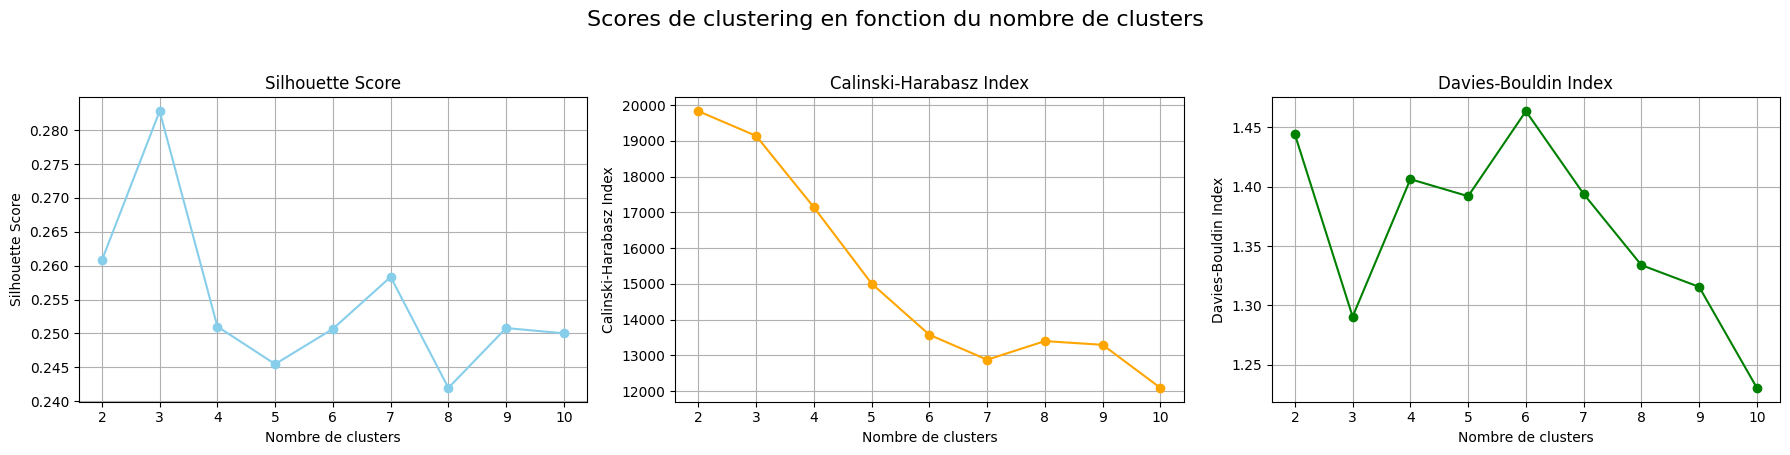

In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

range_n_clusters = range(2, 11)
silhouette_scores, calinski_scores, davies_scores = [], [], []
score_sample_size = 50000

for n in range_n_clusters:
    print(f"Calcul des scores pour {n} clusters...")
    kmeans_tmp = KMeans(n_clusters=n, random_state=42)
    labels_tmp = kmeans_tmp.fit_predict(X_pca)
    # Sous-échantillonnage pour accélérer
    if len(X_pca) > score_sample_size:
        idx = pd.Series(range(len(X_pca))).sample(n=score_sample_size, random_state=42).values
        X_score = X_pca[idx]
        labels_score = [labels_tmp[i] for i in idx]
    else:
        X_score = X_pca
        labels_score = labels_tmp
    if len(set(labels_score)) < 2:
        silhouette_scores.append(np.nan)
        calinski_scores.append(np.nan)
        davies_scores.append(np.nan)
    else:
        silhouette_scores.append(silhouette_score(X_score, labels_score))
        calinski_scores.append(calinski_harabasz_score(X_score, labels_score))
        davies_scores.append(davies_bouldin_score(X_score, labels_score))

# Affichage des scores
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(range_n_clusters, silhouette_scores, marker='o', color='skyblue')
axs[0].set_xlabel('Nombre de clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Score')
axs[0].grid(True)
axs[1].plot(range_n_clusters, calinski_scores, marker='o', color='orange')
axs[1].set_xlabel('Nombre de clusters')
axs[1].set_ylabel('Calinski-Harabasz Index')
axs[1].set_title('Calinski-Harabasz Index')
axs[1].grid(True)
axs[2].plot(range_n_clusters, davies_scores, marker='o', color='green')
axs[2].set_xlabel('Nombre de clusters')
axs[2].set_ylabel('Davies-Bouldin Index')
axs[2].set_title('Davies-Bouldin Index')
axs[2].grid(True)
plt.suptitle('Scores de clustering en fonction du nombre de clusters', fontsize=16)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

## 4. Clustering final et visualisation sur carte
- On fixe le nombre de clusters à 3 (Trouvé avec les métriques)
- On affiche les clusters sur une carte interactive avec Plotly

**Objectif :** Identifier des comportements typiques, détecter des anomalies ou optimiser les itinéraires.

In [20]:
import plotly.express as px

# Clustering principal 
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)
df['cluster'] = labels  # Ajoute la colonne cluster à df (qui contient aussi VesselType_original)

# Évaluation des clusters 
score_full_size = 10000
if len(X_pca) > score_full_size:
    idx_full = pd.Series(range(len(X_pca))).sample(n=score_full_size).values
    X_pca_score = X_pca[idx_full]
    labels_score = [labels[i] for i in idx_full]
else:
    X_pca_score = X_pca
    labels_score = labels

sil_score = silhouette_score(X_pca_score, labels_score)
calinski_score = calinski_harabasz_score(X_pca_score, labels_score)
davies_score = davies_bouldin_score(X_pca_score, labels_score)

print("\n--- Scores de réussite du clustering (toute la base) ---")
print(f"Silhouette Score : {sil_score:.3f}")
print(f"Calinski-Harabasz Index : {calinski_score:.3f}")
print(f"Davies-Bouldin Index : {davies_score:.3f}")

# 8. Visualisation sur carte (échantillon pour performance)
try:
    df_visu = df.sample(n=10000) if len(df) > 5000 else df
    import plotly.io as pio
    pio.renderers.default = "browser"  # Ouvre la carte dans le navigateur par défaut
    fig = px.scatter_mapbox(
        df_visu,
        lat="LAT",
        lon="LON",
        color="cluster",
        hover_data=["SOG", "COG", "Length", "Width", "Draft", "Heading", "VesselType", "VesselType_original"],
        zoom=4,
        mapbox_style="carto-positron",
        title="Clustering des navires sur la carte (toute la base)",
    )
    fig.show()
except Exception as e:
    print("Erreur lors de la visualisation Plotly :", e)



SyntaxError: invalid syntax (930032632.py, line 39)

## 5. Script de prédiction pour un nouveau navire
Ce script permet de prédire le cluster d'un nouveau navire à partir de ses caractéristiques, sans relancer le clustering.

Il suffit de charger les modèles sauvegardés et d'utiliser la fonction ci-dessous.

In [16]:
import joblib

def predict_cluster(new_data_dict):
    """
    Prédit le cluster d'un nouveau navire à partir de ses caractéristiques.
    new_data_dict : dict avec les clés ['LAT', 'LON', 'SOG', 'COG', 'Length', 'Width', 'Draft', 'Heading', 'VesselType']
    """
    scaler = joblib.load('scaler_model.joblib')
    pca = joblib.load('pca_model.joblib')
    kmeans = joblib.load('kmeans_model.joblib')
    le = joblib.load('labelencoder_vesseltype.joblib')
    new_df = pd.DataFrame([new_data_dict])
    if 'VesselType' in new_df.columns:
        if new_df['VesselType'].iloc[0] not in le.classes_:
            raise ValueError(f"VesselType inconnu : {new_df['VesselType'].iloc[0]}. Valeurs connues : {list(le.classes_)}")
        new_df['VesselType'] = le.transform(new_df['VesselType'])
    model_features = ['LAT', 'LON', 'SOG', 'COG', 'Length', 'Width', 'Draft', 'Heading', 'VesselType']
    X_new = scaler.transform(new_df[model_features])
    X_new_pca = pca.transform(X_new)
    cluster = kmeans.predict(X_new_pca)
    return cluster[0]

# Exemple d'utilisation
exemple_navire = {'LAT': 29.0, 'LON': -89.0, 'SOG': 10.0, 'COG': 200.0, 'Length': 100, 'Width': 20, 'Draft': 8, 'Heading': 200, 'VesselType': 60}
print('Cluster prédit :', predict_cluster(exemple_navire))

Cluster prédit : 1
